<p>This tutorial presents <a href="">Neural Combinatorial Optimization with Reinforcement Learning</a>. Focusing on the traveling salesman problem (TSP) and train a recurrent neural network that, given a set of city coordinates, predicts a distribution over different city permutations. Using
negative tour length as the reward signal, the model optimize the parameters of the recurrent
neural network using a policy gradient method. </p><p>Despite the computational expense, without much engineering and
heuristic designing, Neural Combinatorial Optimization achieves close to optimal
results on 2D Euclidean graphs with up to 100 nodes.</p><p>
Previous attempts used supervised learning. Learning from examples in such a
way is undesirable for NP-hard problems because (1) the performance of the model is tied to the
quality of the supervised labels, (2) getting high-quality labeled data is expensive and may be infeasible
for new problem statements, (3) one cares more about finding a competitive solution more than
replicating the results of another algorithm. By contrast, Reinforcement Learning (RL) provides an appropriate paradigm for training
neural networks for combinatorial optimization, especially because these problems have relatively
simple reward mechanisms that could be even used at test time. </p>

### Package

In [252]:
import math
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

USE_CUDA = True
seed = 2
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.__version__)
torch.set_printoptions(edgeitems=10)

1
Tesla P100-PCIE-16GB
1.12.1+cu113


In [253]:
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [254]:
# save in the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h3>Generating dataset for TSP Task</h3>

In [255]:
class TSPDataset(Dataset):
    
    def __init__(self, num_nodes, num_samples, random_seed=111):
        super(TSPDataset, self).__init__()
        torch.manual_seed(random_seed)

        self.data_set = []
        for l in tqdm(range(num_samples)):
            x = torch.FloatTensor(2, num_nodes).uniform_(0, 1)
            self.data_set.append(x)

        self.size = len(self.data_set)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data_set[idx]

### Create dataset for ride-sharing problem: [coordinates, is_pickup_or_dropoff, request_id]

In [256]:
num_nodes = 20
x = torch.FloatTensor(2, num_nodes).uniform_(0, 1)
pickup = torch.ones([1, int(num_nodes / 2)], dtype = torch.float64)
dropoff = torch.zeros([1, int(num_nodes / 2)], dtype = torch.float64)
pickup_or_dropoff = torch.cat([pickup, dropoff], 1)
id = torch.arange(10).repeat(1,2)
data = torch.cat([x, pickup_or_dropoff, id], 0)
data
data[0:2]

tensor([[0.6147, 0.3810, 0.6371, 0.4745, 0.7136, 0.6190, 0.4425, 0.0958, 0.6142,
         0.0573, 0.5657, 0.5332, 0.3901, 0.9088, 0.5334, 0.7073, 0.7116, 0.2050,
         0.3078, 0.9809],
        [0.0103, 0.4660, 0.4604, 0.8547, 0.4525, 0.6317, 0.4760, 0.2200, 0.2166,
         0.2571, 0.0458, 0.1755, 0.6177, 0.8291, 0.5246, 0.2708, 0.7197, 0.3081,
         0.3892, 0.2259]], dtype=torch.float64)

### test dataset

In [257]:
# train_size = 1000000
train_size = 10000
val_size = 1000
# val_size = 10000

In [258]:
train_9_dataset = TSPDataset(9, train_size)
val_9_dataset   = TSPDataset(9, val_size)

train_21_dataset = TSPDataset(21, train_size)
val_21_dataset   = TSPDataset(21, val_size)

# train_50_dataset = TSPDataset(50, train_size)
# val_50_dataset   = TSPDataset(50, val_size)

100%|██████████| 1000/1000 [00:00<00:00, 74200.01it/s]


### Reward
<p>
Given an input graph, represented as a sequence of n cities in a two dimensional space, the task is finding a permutation of the points π, termed a tour, that visits each city once and has the minimum
total length. Tthe length of a tour is defined by a permutation π.
</p>

In [259]:
def reward(sample_solution, action_idxs, use_cuda = True):
    """
    Args:
        sample_solution seq_len of [batch_size]
    """
    batch_size = sample_solution[0].size(0)
    n = len(sample_solution)
    # passs = 10
    # tour_len = Variable(torch.zeros([batch_size]))
    route_len = Variable(torch.zeros([batch_size]))
    # tour_wait = Variable(torch.zeros([batch_size]))
    # num_passengers = Variable(torch.zeros([batch_size]))
    # num_non_pick_up = Variable(torch.zeros([batch_size]))
    # num_pick_up = Variable(torch.zeros([batch_size]))

    # num_serve = Variable(torch.ones([batch_size])*passs)
    # num_passengers = Variable(torch.ones([batch_size])*(-1))

    if USE_CUDA:
        # tour_len = tour_len.cuda()
        route_len = route_len.cuda()
        # tour_wait = tour_wait.cuda()
        # num_passengers = num_passengers.cuda()
        # num_serve = num_serve.cuda()
        # num_non_pick_up = num_non_pick_up.cuda()
    # if n != 0:



    for i in range(n-1):
      # num_serve[torch.where(action_idxs[i] == 0, True, False)] += 1
      # num_serve[torch.where(action_idxs[i] < n / 2, True, False)] -= 1
     
      # num_passengers[torch.where(action_idxs[i] == 0, True, False)] -= 1
      # num_passengers[torch.where(action_idxs[i] < n / 2, True, False)] += 1 
      # num_passengers[torch.where(action_idxs[i] > n / 2, True, False)] -= 1 

      # if torch.where(action_idxs[i] < 0, True, False).any():
          # print('Error: negative num_passengers!')

      # tour_len += num_passengers * torch.norm(sample_solution[i+1] - sample_solution[i], p = 2,dim=1)
      route_len += torch.norm(sample_solution[i+1] - sample_solution[i], p = 2, dim = 1)
    
    # tour_len += torch.norm(sample_solution[n - 1] - sample_solution[0], dim=1)
    
    # tour_wait = num_serve * route_len
    # reward = 0.3*tour_len+0.2*route_len+ 0.5*tour_wait

    return route_len



### Attention mechanism

<p>
Using two types of attention mechanism: "Dot" and "Bahdanau" . More details in <a href="http://aclweb.org/anthology/D15-1166">Effective Approaches to Attention-based Neural Machine Translation</a></p>

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & Dot \\
v_a ^\top \tanh(\textbf{W}_a [ h_t ; \bar h_s ]) & Bahdanau
\end{cases}
$$

In [260]:
class Attention(nn.Module):
    def __init__(self, hidden_size, use_tanh=False, C=10, name='Bahdanau', use_cuda=USE_CUDA):
        super(Attention, self).__init__()
        
        self.use_tanh = use_tanh
        self.C = C
        self.name = name
        
        if name == 'Bahdanau':
            self.W_query = nn.Linear(hidden_size, hidden_size)
            self.W_ref   = nn.Conv1d(hidden_size, hidden_size, 1, 1)

            V = torch.FloatTensor(hidden_size)
            if use_cuda:
                V = V.cuda()  
            self.V = nn.Parameter(V)
            self.V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
            
        
    def forward(self, query, ref):
        """
        Args: 
            query: [batch_size x hidden_size]
            ref:   ]batch_size x seq_len x hidden_size]
        """
        
        batch_size = ref.size(0)
        seq_len    = ref.size(1)
        
        if self.name == 'Bahdanau':
            ref = ref.permute(0, 2, 1)
            query = self.W_query(query).unsqueeze(2)  # [batch_size x hidden_size x 1]
            ref   = self.W_ref(ref)  # [batch_size x hidden_size x seq_len] 
            expanded_query = query.repeat(1, 1, seq_len) # [batch_size x hidden_size x seq_len]
            V = self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1) # [batch_size x 1 x hidden_size]
            logits = torch.bmm(V, F.tanh(expanded_query + ref)).squeeze(1)
            
        elif self.name == 'Dot':
            query  = query.unsqueeze(2)
            logits = torch.bmm(ref, query).squeeze(2) #[batch_size x seq_len x 1]
            ref = ref.permute(0, 2, 1)
        
        else:
            raise NotImplementedError
        
        if self.use_tanh:
            logits = self.C * F.tanh(logits)
        else:
            logits = logits  
        return ref, logits

<h3>Graph Embedding</h3>
<p>
This is simple node embedding. For more advanced methods see <a href="https://arxiv.org/pdf/1705.02801.pdf">Graph Embedding Techniques, Applications, and Performance: A Survey</a>
</p>

In [261]:
class GraphEmbedding(nn.Module):
    def __init__(self, input_size, embedding_size, use_cuda=USE_CUDA):
        super(GraphEmbedding, self).__init__()
        self.embedding_size = embedding_size
        self.use_cuda = use_cuda
        
        self.embedding = nn.Parameter(torch.FloatTensor(input_size, embedding_size)) 
        self.embedding.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
    def forward(self, inputs):
        batch_size = inputs.size(0)
        seq_len    = inputs.size(2)
        embedding = self.embedding.repeat(batch_size, 1, 1)  
        embedded = []

        inputs = inputs.unsqueeze(1)
        for i in range(seq_len):
            embedded.append(torch.bmm(inputs[:, :, :, i].float(), embedding))
        
        embedded = torch.cat(embedded, 1)
        
        return embedded

### Update

In [262]:
def update(prev_idx, demands, capacity):
    '''
    update states
    
    Args:
    prev_idx (tensor or None): (batch_size,)
    demands (tensor): (batch_size, 1, seq_len)

    '''
    req_num = 10
    demands = demands.cpu()
    prev_idx = prev_idx.cpu()
    req = torch.ones(128,).long()*req_num

    # depot : no change
    if prev_idx is None:
        return demands
    
    batch_size, seq_len = demands.size()[0], demands.size()[1]

    if prev_idx.sum() == 0:

      return demands

    # visited point

    demands[[b for b in range(batch_size)], prev_idx.data] = 0
    # change_num
    pick_up = (prev_idx<=10).data

    for j,i in enumerate(pick_up):
      if i:
        demands[j, prev_idx[j]+req_num] = 1
        
    
    return demands

def make_demands(size = 128, req_num = 10):
    demands = torch.randint(0, 1, (size, 2*req_num+1))
    vrp_num = req_num
    demands[:,0]=0
    demands[[b for b in range(size)], 1:] = 1
    demands[[b for b in range(size)], 1+req_num:] = 0
    return demands
demands = make_demands()
print(demands[120])

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Pointer Network and Mask
<p><a href="https://arxiv.org/abs/1506.03134">Pointer Networks
</a></p>
<p>Check my tutorial - <a href="https://github.com/higgsfield/np-hard-deep-reinforcement-learning/blob/master/Intro%20to%20Pointer%20Network.ipynb">intro to Pointer Networks</a></p>
<p>The model solves the problem of variable size output dictionaries using a recently proposed mechanism of neural attention. It differs from the previous attention attempts in that, instead of using attention to blend hidden units of an encoder to a context vector at each decoder step, it uses attention as a pointer to select a member of the input sequence as the output.</p>
<img src="imgs/Снимок экрана 2017-12-26 в 4.30.58 ДП.png">

In [263]:
class PointerNet(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            attention,
            use_cuda=USE_CUDA):
        super(PointerNet, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        
        self.embedding = GraphEmbedding(2, embedding_size, use_cuda=use_cuda)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, name=attention, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, name=attention, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
    def apply_mask_to_logits(self, logits, mask, idxs, prev_idxs,demands): 
        
        batch_size = logits.size(0)
        clone_mask = mask.clone()
        prev_id = idxs
        # change_req_num
        atch_size, seq_len = logits.size()
        req= 10


        # first node must be depot
        if len(prev_idxs) == 0:

          clone_mask[[i for i in range(batch_size)], 1:] = 1
          logits[clone_mask] = -np.inf
          # logits[:, 0] = 1
          # logits[:, 1:] = 0
          
          # print(clone_mask)
          # print(logits.size())
          return logits,clone_mask



        # mask zero demands
        zero_demands = (demands == 0).data.byte()
        # zero_demands[[b for b in range(batch_size)], 0] = 0 # don't mask depot
        logits[zero_demands] = -np.inf
  
     
        return logits, clone_mask
            
    def forward(self, inputs):
        """
        Args: 
            inputs: [batch_size x 1 x sourceL]
        """
        batch_size = inputs.size(0)
        seq_len    = inputs.size(2)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        
        prev_probs = []
        prev_idxs = []
        # change num
        demands = make_demands(batch_size, 10)
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
            
        idxs = None
       
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        for i in range(seq_len):
            
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for i in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)

                # logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs, prev_idxs,demands)

                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) 
                
                
            _, logits = self.pointer(query, encoder_outputs)

            # logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs, prev_idxs,demands)

            
            probs = F.softmax(logits)      

            # sample or greedy
            # idxs = probs.multinomial(num_samples=1).squeeze(1)

            idxs = torch.argmax(probs, dim = 1).long()
  

            demands = update(idxs, demands, capacity = 8)
            if self.use_cuda:
              demands = demands.cuda()

            for old_idxs in prev_idxs:
                if old_idxs.eq(idxs).data.any():
                    idxs = probs.multinomial(num_samples = 1).squeeze(1)
                    break
            decoder_input = embedded[[i for i in range(batch_size)], idxs.data, :] 
            
            prev_probs.append(probs)
            prev_idxs.append(idxs)

            

        return prev_probs, prev_idxs

### Netmodel
<p>Model-free policy-based Reinforcement Learning to optimize the parameters of a pointer network using the well-known REINFORCE algorithm</p>

In [264]:
class CombinatorialRL(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            reward,
            attention,
            use_cuda=USE_CUDA):
        super(CombinatorialRL, self).__init__()
        self.reward = reward
        self.use_cuda = use_cuda
        
        self.actor = PointerNet(
                embedding_size,
                hidden_size,
                seq_len,
                n_glimpses,
                tanh_exploration,
                use_tanh,
                attention,
                use_cuda)
        self.seq_len = seq_len


    def forward(self, inputs):
        """
        Args:
            inputs: [batch_size, input_size, seq_len]
        """
        batch_size = inputs.size(0)
        input_size = inputs.size(1)
        seq_len    = inputs.size(2)
        
        probs, action_idxs = self.actor(inputs)
       
        actions = []

        inputs = inputs.transpose(1, 2)
        for action_id in action_idxs:
            actions.append(inputs[[x for x in range(batch_size)], action_id.data, :])

            
        action_probs = []    
        for prob, action_id in zip(probs, action_idxs):
            action_probs.append(prob[[x for x in range(batch_size)], action_id.data])

        # R = self.reward(actions, self.use_cuda)

        R = self.reward(actions, action_idxs, self.use_cuda)
        
        return R, action_probs, actions, action_idxs

### Parameters

In [265]:
embedding_size = 128
hidden_size    = 128
n_glimpses = 1
tanh_exploration = 10
use_tanh = True

beta = 0.9
max_grad_norm = 2.

### Creating two models:
<h3>1. Pointer Network with Dot Attention - TSP 20</h3><h3> 2. Pointer Network with Bahdanau Attention - TSP 50</h3>

In [266]:

tsp_21_model = CombinatorialRL(
        embedding_size,
        hidden_size,
        21,
        n_glimpses, 
        tanh_exploration,
        use_tanh,
        reward,
        attention="Dot",
        use_cuda=USE_CUDA)

# tsp_50_model = CombinatorialRL(
#         embedding_size,
#         hidden_size,
#         50,
#         n_glimpses, 
#         tanh_exploration,
#         use_tanh,
#         reward,
#         attention="Bahdanau",
#         use_cuda=USE_CUDA)

tsp_9_model = CombinatorialRL(
        embedding_size,
        hidden_size,
        9,
        n_glimpses, 
        tanh_exploration,
        use_tanh,
        reward,
        attention="Dot",
        use_cuda=USE_CUDA)

In [267]:
if USE_CUDA:
    # tsp_9_model = tsp_9_model.cuda()
    tsp_21_model = tsp_21_model.cuda()
    # tsp_50_model = tsp_50_model.cuda()

### Train 

In [268]:
class TrainModel:
    def __init__(self, model, train_dataset, val_dataset, l_r ,batch_size=256, threshold=None, max_grad_norm=2.):
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset   = val_dataset
        self.batch_size = batch_size
        self.threshold = threshold
        
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
        self.val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

        self.actor_optim   = optim.Adam(model.actor.parameters(), lr=l_r)
        self.max_grad_norm = max_grad_norm
        
        self.train_tour = []
        self.val_tour   = []
        
        self.epochs = 0
    
    def train_and_validate(self, n_epochs):
        critic_exp_mvg_avg = torch.zeros(1)
        if USE_CUDA: 
            critic_exp_mvg_avg = critic_exp_mvg_avg.cuda()

        for epoch in range(n_epochs):
            for batch_id, sample_batch in enumerate(self.train_loader):
                self.model.train()

                inputs = Variable(sample_batch)
                inputs = inputs.cuda()

                R, probs, actions, actions_idxs = self.model(inputs)

                if batch_id == 0:
                    critic_exp_mvg_avg = R.mean()
                else:
                    critic_exp_mvg_avg = (critic_exp_mvg_avg * beta) + ((1. - beta) * R.mean())


                advantage = R - critic_exp_mvg_avg

                logprobs = 0
                for prob in probs: 
                    logprob = torch.log(prob)
                    logprobs += logprob
                logprobs[logprobs < -1000] = 0.  

                reinforce = advantage * logprobs
                actor_loss = reinforce.mean()

                self.actor_optim.zero_grad()
                actor_loss.backward()
                torch.nn.utils.clip_grad_norm(self.model.actor.parameters(),
                                    float(self.max_grad_norm), norm_type=2)

                self.actor_optim.step()

                critic_exp_mvg_avg = critic_exp_mvg_avg.detach()

                self.train_tour.append(R.mean().data)

                if batch_id % 10 == 0:
                    # self.plot(self.epochs)
                    self.plot(self.epochs)

                if batch_id % 100 == 0:    

                    self.model.eval()
                    for val_batch in self.val_loader:
                        inputs = Variable(val_batch)
                        inputs = inputs.cuda()

                        R, probs, actions, actions_idxs = self.model(inputs)
                        # print('actions_idxs:', actions_idxs)
                        self.val_tour.append(R.mean().data)
                

            

            if self.epochs % 10 == 0:
                    torch.save(self.model, os.path.join('/content/drive/MyDrive/model_21/', \
                                                            'model_tsp{}_mvg_avg_{}.pt'.format(self.model.seq_len,str(self.epochs))))
            if self.threshold and self.train_tour[-1] < self.threshold:
                print("EARLY STOPPAGE!")
                break
                
            self.epochs += 1
                
    def plot(self, epoch):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('train tour length: epoch %s reward %s' % (epoch, self.train_tour[-1] if len(self.train_tour) else 'collecting'))
        # plt.plot(self.train_tour)
        plt.plot([item.detach().cpu().clone().numpy() for item in self.train_tour])
        plt.grid()
        plt.subplot(132)
        plt.title('val tour length: epoch %s reward %s' % (epoch, self.val_tour[-1] if len(self.val_tour) else 'collecting'))
        # plt.plot(self.val_tour)
        plt.plot([item.detach().cpu().clone().numpy() for item in self.val_tour])
        plt.grid()
        plt.show()

<h2>TSP 20 Results of Pointer Network with Dot Attention</h2>

In [269]:
tsp_21_train = TrainModel(tsp_21_model, 
                        train_21_dataset, 
                        val_21_dataset, l_r = 1e-3)
# tsp_20_train = TrainModel(tsp_20_model, 
#                         train_20_dataset, 
#                         val_20_dataset, 
#                         threshold=6.99)

# tsp_9_train = TrainModel(tsp_9_model, 
#                         train_9_dataset, 
#                         val_9_dataset,l_r = 8e-4)
# 3500/10min/70sp
# 

# AAEBAa0GDtcKt7sCws4CoIADjYIDl4cD2IkD1pkDmJsDmZsDoaED0aUDmakD3tIDCNMK+hHRwQLlzALmzAK0zgLj6QKClAMA

### Train model

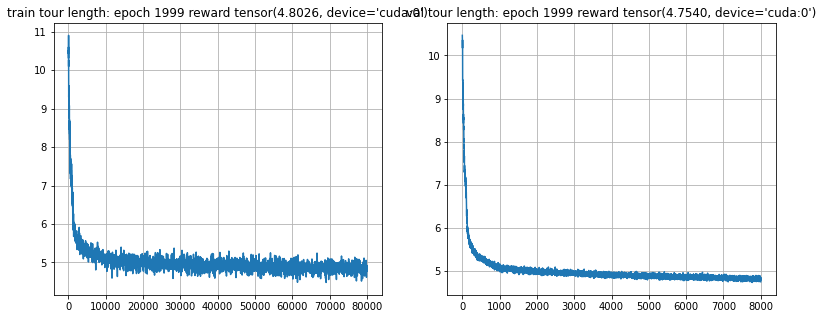

In [210]:
tsp_21_train.train_and_validate(2000)

### Test trained model

## mean reward

In [270]:
val_21_dataset = torch.load('/content/val_21_dataset.pt')
val_loader   = DataLoader(val_21_dataset, batch_size=1000, shuffle=True, num_workers=1)
for val in val_loader:
  testv = Variable(val).cuda()
model_t = torch.load('/content/drive/MyDrive/model_21/model_tsp21_mvg_avg_1990.pt')
R, probs, actions, actions_idxs = model_t(testv)
# 4.6667， 1990， epoch
R.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1239.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1239.)


tensor(4.6667, device='cuda:0')

In [ ]:
test_id = 100
test_instance_no = test_id
testv = val_9_dataset[test_id].unsqueeze(0).cuda()

model_t = torch.load('/content/drive/MyDrive/model_lr_0.001/model_tsp9_mvg_avg_200.pt')

R, probs, actions, actions_idxs = model_t(testv)

print(R)
ac_list = []
for i in actions_idxs:
  ac_list.append(i.cpu().item())

print(ac_list)
# print(actions)
# print(actions_idxs)

tensor([2.6674], device='cuda:0')
[0, 1, 2, 4, 6, 8, 3, 5, 7]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1239.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1239.)


In [ ]:
testv = val_9_dataset[test_id]
testv

tensor([[0.9984, 0.9867, 0.1933, 0.3735, 0.0988, 0.6278, 0.1049, 0.9091, 0.0827],
        [0.8769, 0.9841, 0.6851, 0.3889, 0.7896, 0.1782, 0.6465, 0.2760, 0.1963]])

In [ ]:
def reward_tl_t(sample_solution, action_idxs, use_cuda = True):
    """
    Args:
        sample_solution seq_len of [batch_size]
    """
    batch_size = sample_solution[0].size(0)
    n = len(sample_solution)
    passs = 4
    tour_len = Variable(torch.zeros([batch_size]))

    num_serve = Variable(torch.ones([batch_size])*passs)
    # num_passengers = Variable(torch.ones([batch_size])*(-1))

    if USE_CUDA:
        tour_len = tour_len.cuda()
        

    for i in range(n-1):
    
      tour_len += torch.norm(sample_solution[i+1] - sample_solution[i], p = 2, dim = 1)
    
    reward = tour_len

    return reward


### TEST without training

In [ ]:
test_id = 12
# val_set_t = Variable(torch.cat(val_9_dataset).view(len(val_9_dataset), -1, 2))
testv = val_9_dataset[34].unsqueeze(0).cuda()
# testv.shape

model_t_3 = torch.load('/content/model_tsp9_mvg_avg_40.pt')

R, probs, actions, actions_idxs = model_t_3(testv)
ac_list = []
for i in actions_idxs:
  ac_list.append(i.cpu().item())

print(ac_list)

[0, 3, 4, 7, 2, 6, 8, 1, 5]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1239.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1239.)


### Plot

In [ ]:
index_list = actions_idxs
pi = actions
List_all = []
list1 =[]
pii,pii_x,pii_y = [],[],[]
Pi_all,Pi_all_x,Pi_all_y = [],[],[]
# for j in range(len(x)):
for i in range(9):
    list1.append(index_list[i].item())
    pii.append(pi[i].data)
    pii_x.append(pi[i].data.tolist()[0][0])
    pii_y.append(pi[i].data.tolist()[0][1])


print("index list: ", list1)
print("Policy: ", pii)
print("Policy_x: ", pii_x)
print("Policy_y: ", pii_y)

index list:  [0, 2, 6, 3, 7, 4, 8, 1, 5]
Policy:  [tensor([[0.9984, 0.8769]], device='cuda:0'), tensor([[0.1933, 0.6851]], device='cuda:0'), tensor([[0.1049, 0.6465]], device='cuda:0'), tensor([[0.3735, 0.3889]], device='cuda:0'), tensor([[0.9091, 0.2760]], device='cuda:0'), tensor([[0.0988, 0.7896]], device='cuda:0'), tensor([[0.0827, 0.1963]], device='cuda:0'), tensor([[0.9867, 0.9841]], device='cuda:0'), tensor([[0.6278, 0.1782]], device='cuda:0')]
Policy_x:  [0.9983533620834351, 0.19333499670028687, 0.10488826036453247, 0.3734968900680542, 0.9091227054595947, 0.0988282561302185, 0.08273828029632568, 0.986666202545166, 0.6277743577957153]
Policy_y:  [0.876876950263977, 0.6851080656051636, 0.6465128064155579, 0.3889370560646057, 0.2759941816329956, 0.7896295189857483, 0.19634908437728882, 0.984107494354248, 0.1781575083732605]


In [ ]:
node = val_9_dataset[test_id]
print(node.data[0].tolist())
print(node.data[1].tolist())

[0.597483217716217, 0.3100038170814514, 0.3923097252845764, 0.16851413249969482, 0.6725608110427856, 0.08331221342086792, 0.26188552379608154, 0.19082438945770264, 0.8591622710227966]
[0.7617321610450745, 0.20496928691864014, 0.5799458622932434, 0.9806379079818726, 0.8466377258300781, 0.5225498080253601, 0.8318077921867371, 0.7602040767669678, 0.12986105680465698]


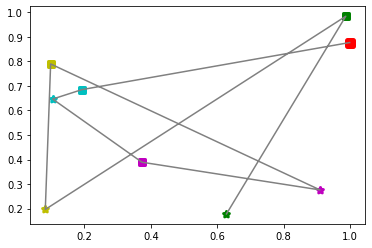

In [ ]:
x = pii_x
y = pii_y
node = val_9_dataset[test_id]
# print("index list: ", List_all[test_instance_no])
# print("Policy: ", Pi_all[test_instance_no])
# print("Policy_x: ", Pi_all_x[test_instance_no])
# print("Policy_y: ", Pi_all_y[test_instance_no])

plt.plot(x, y, c="gray")
req_num = 4
color = ['b','g','c','m','y','orange','pink']
plt.scatter(x[0], y[0], c = "r", marker = "s", linewidths = 5)
for i in range(1,req_num+1):
  plt.scatter(node.data[0].tolist()[i], node.data[1].tolist()[i], c = color[i], marker = "s", linewidths = 3)
  plt.scatter(node.data[0].tolist()[i+req_num], node.data[1].tolist()[i+req_num], c = color[i], marker = "*", linewidths = 3)

<h2>TSP 50 Results of Pointer Network with Bahdanau Attention</h2>


In [ ]:
# train_50_train = TrainModel(tsp_50_model, 
#                             train_50_dataset, 
#                             val_50_dataset, 
#                             threshold=6.4)

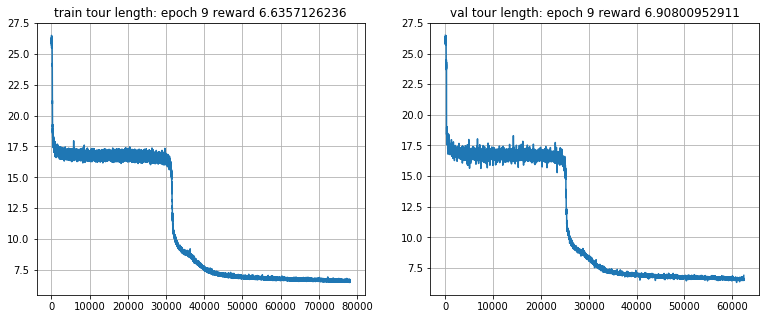

In [ ]:
# train_50_train.train_and_validate(10)